# Regression Model

Objectives:
Understanding the dataset;
Data cleaning and data analysis;
Build models to predict
Explain the model.

## 1. Data Analysis & Cleaning

In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from math import sqrt
import sys
%matplotlib inline

import mlxtend
from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge

import optuna
from optuna.samplers import TPESampler
import catboost
from catboost import CatBoostRegressor
from catboost.utils import get_roc_curve
from catboost.utils import eval_metric
import  warnings
warnings.simplefilter('ignore')
import shap

In [7]:
pd.set_option("display.max_columns", None)
mpl.rcParams['figure.figsize'] = (12, 10)
#plt.rcParams['axes.labelsize'] = 15
font = {'weight' : 'bold', 'size'   : 15}
plt.rc('font', **font)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [8]:
data = pd.read_csv('real_estate_data.csv')
data.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002


It is obvious that *'tx_price'* is the y_label we want to predict.

### 1.1 Understanding the dataset

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tx_price            1883 non-null   int64  
 1   beds                1883 non-null   int64  
 2   baths               1883 non-null   int64  
 3   sqft                1883 non-null   int64  
 4   year_built          1883 non-null   int64  
 5   lot_size            1883 non-null   int64  
 6   property_type       1883 non-null   object 
 7   exterior_walls      1660 non-null   object 
 8   roof                1529 non-null   object 
 9   basement            1657 non-null   float64
 10  restaurants         1883 non-null   int64  
 11  groceries           1883 non-null   int64  
 12  nightlife           1883 non-null   int64  
 13  cafes               1883 non-null   int64  
 14  shopping            1883 non-null   int64  
 15  arts_entertainment  1883 non-null   int64  
 16  beauty

In [10]:
data.isnull().sum()

tx_price                0
beds                    0
baths                   0
sqft                    0
year_built              0
lot_size                0
property_type           0
exterior_walls        223
roof                  354
basement              226
restaurants             0
groceries               0
nightlife               0
cafes                   0
shopping                0
arts_entertainment      0
beauty_spas             0
active_life             0
median_age              0
married                 0
college_grad            0
property_tax            0
insurance               0
median_school           0
num_schools             0
tx_year                 0
dtype: int64

In [11]:
data.shape

(1883, 26)

In [12]:
data.describe()

,tx_price,beds,baths,sqft,year_built,lot_size,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1.883000e+03,1657.0,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,422839.807754,3.420605,2.579926,2329.398832,1982.963887,1.339262e+04,1.0,40.210303,4.505045,5.074881,5.325013,40.802443,3.394052,23.416888,15.835369,38.601168,69.091875,65.085502,466.777483,140.454063,6.502921,2.793415,2007.111524
std,151462.593276,1.068554,0.945576,1336.991858,20.295945,4.494930e+04,0.0,46.867012,4.491029,8.464668,7.539309,53.539296,4.699787,25.776916,17.667717,6.634110,19.659767,16.953165,231.656645,72.929765,1.996109,0.505358,5.196898
min,200000.000000,1.000000,1.000000,500.000000,1880.000000,0.000000e+00,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.000000,11.000000,5.000000,88.000000,30.000000,1.000000,1.000000,1993.000000
25%,300000.000000,3.000000,2.000000,1345.000000,1970.000000,1.542000e+03,1.0,7.000000,1.000000,0.000000,0.000000,6.000000,0.000000,4.000000,4.000000,33.000000,58.000000,54.000000,320.000000,94.000000,5.000000,3.000000,2004.000000
50%,392000.000000,3.000000,3.000000,1907.000000,1986.000000,6.098000e+03,1.0,23.000000,3.000000,2.000000,3.000000,22.000000,2.000000,15.000000,10.000000,38.000000,73.000000,66.000000,426.000000,125.000000,7.000000,3.000000,2007.000000
75%,525000.000000,4.000000,3.000000,3005.000000,2000.000000,1.176100e+04,1.0,58.000000,7.000000,6.000000,6.000000,51.000000,5.000000,35.000000,21.000000,43.000000,84.000000,78.000000,569.000000,169.000000,8.000000,3.000000,2011.000000
max,800000.000000,5.000000,6.000000,8450.000000,2015.000000,1.220551e+06,1.0,266.000000,24.000000,54.000000,47.000000,340.000000,35.000000,177.000000,94.000000,69.000000,100.000000,100.000000,4508.000000,1374.000000,10.000000,4.000000,2016.000000


In [13]:
#change the type mrfei from object to float
#data['mrfei'] = data['mrfei'].astype(float, errors = 'raise')
#data['mrfei'] = pd.to_numeric(data['mrfei'],errors = 'coerce')

### 1.2 Understanding the numerical variables

In [14]:
col_num = data.select_dtypes(exclude = ['object']).columns.tolist()
col_num

['tx_price',
 'beds',
 'baths',
 'sqft',
 'year_built',
 'lot_size',
 'basement',
 'restaurants',
 'groceries',
 'nightlife',
 'cafes',
 'shopping',
 'arts_entertainment',
 'beauty_spas',
 'active_life',
 'median_age',
 'married',
 'college_grad',
 'property_tax',
 'insurance',
 'median_school',
 'num_schools',
 'tx_year']

array([[<AxesSubplot:title={'center':'tx_price'}>,
        <AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'baths'}>,
        <AxesSubplot:title={'center':'sqft'}>,
        <AxesSubplot:title={'center':'year_built'}>],
       [<AxesSubplot:title={'center':'lot_size'}>,
        <AxesSubplot:title={'center':'basement'}>,
        <AxesSubplot:title={'center':'restaurants'}>,
        <AxesSubplot:title={'center':'groceries'}>,
        <AxesSubplot:title={'center':'nightlife'}>],
       [<AxesSubplot:title={'center':'cafes'}>,
        <AxesSubplot:title={'center':'shopping'}>,
        <AxesSubplot:title={'center':'arts_entertainment'}>,
        <AxesSubplot:title={'center':'beauty_spas'}>,
        <AxesSubplot:title={'center':'active_life'}>],
       [<AxesSubplot:title={'center':'median_age'}>,
        <AxesSubplot:title={'center':'married'}>,
        <AxesSubplot:title={'center':'college_grad'}>,
        <AxesSubplot:title={'center':'property_tax'}>,
        <A

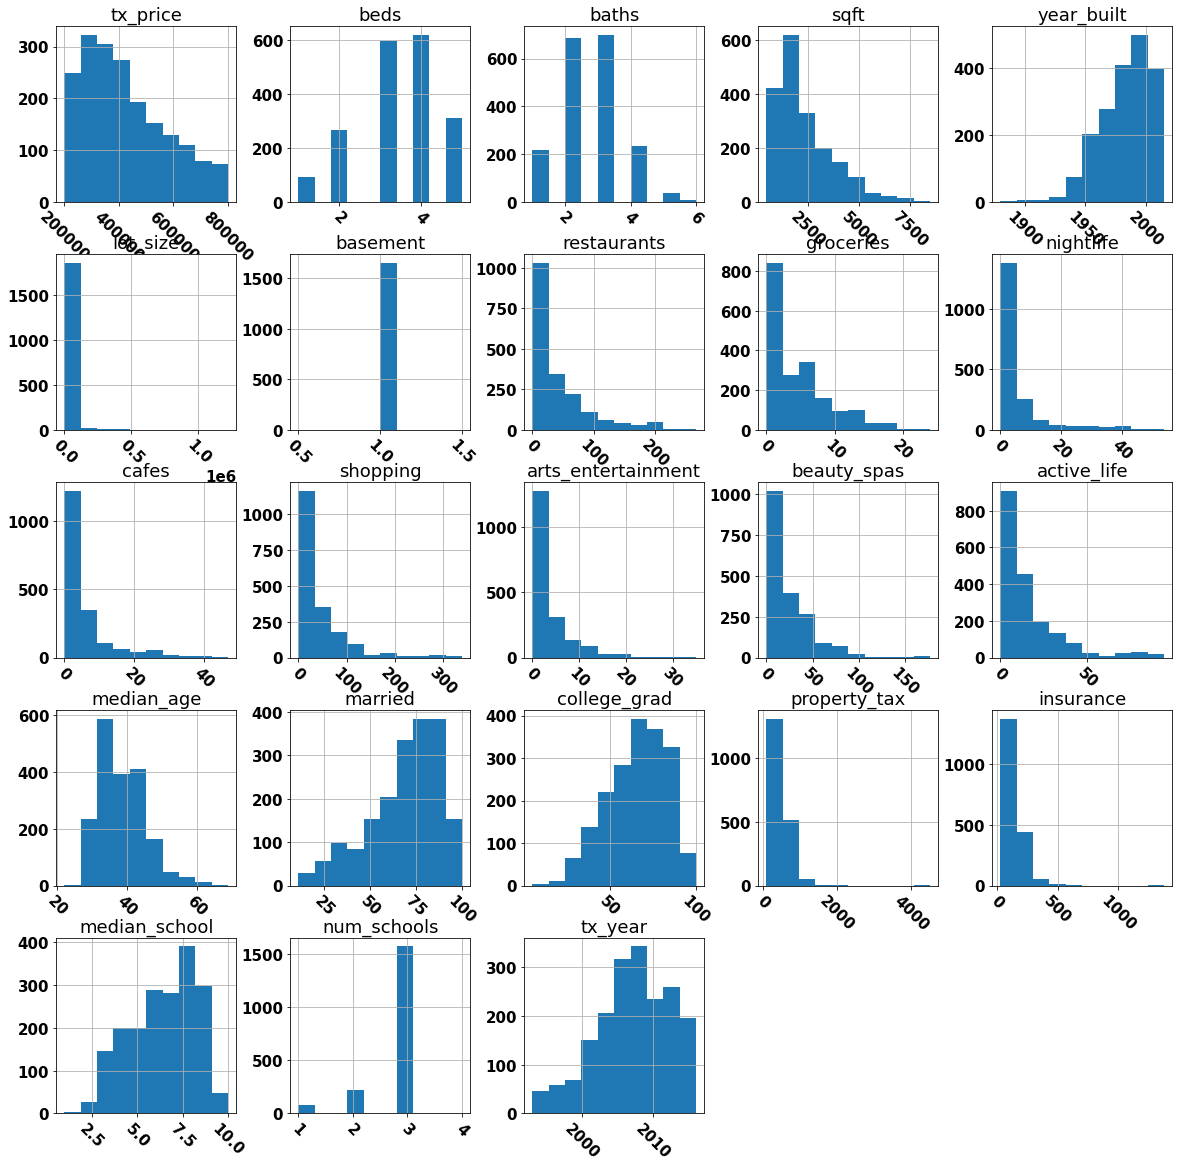

In [15]:
data.hist(figsize=(20,20), xrot=-45)

note: lot_size has outliers; will need to be investigated further.

#### Distribution of target variable(tx_price)

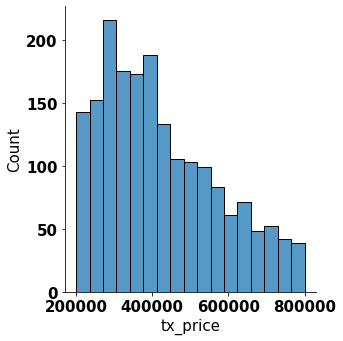

In [16]:
sns.displot(data, x="tx_price")

In [17]:
data.tx_price.median()

392000.0

#### Missing Values

In [18]:
data.select_dtypes(exclude=['object']).isnull().sum()

tx_price                0
beds                    0
baths                   0
sqft                    0
year_built              0
lot_size                0
basement              226
restaurants             0
groceries               0
nightlife               0
cafes                   0
shopping                0
arts_entertainment      0
beauty_spas             0
active_life             0
median_age              0
married                 0
college_grad            0
property_tax            0
insurance               0
median_school           0
num_schools             0
tx_year                 0
dtype: int64

A closer examination of the basement feature suggests that rows with basement=0 were encoded with NaN. Hence this is actually an incorrect labelling problem. We’ll need to convert NaN’s to 0 for the algorithms.
Note: If these NaN’s were genuine missing values, we should create an indicator variable basement_missing (with value 1 when basement=NaN) before converting the NaNs in basement to 0.

In [19]:
data['basement_missing'] = np.where(data['basement'].isna(), 1,0)
#df['hasimage'] = np.where(df['photos']!= '[]', True, False)
data.head(5)

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,basement_missing
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013,1
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006,0
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012,1
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood Siding,NaN,NaN,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005,1
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,NaN,NaN,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002,1


In [20]:
data.basement.fillna(0, inplace=True)
data.basement.unique() # No more NaN values!

array([0., 1.])

#### Outliers

In [21]:
#lot_size has some outliers
data['lot_size'].sort_values(ascending=False)

102     1220551
1111     436471
1832     436035
1876     436035
1839     435600
         ...   
285           0
286           0
287           0
288           0
0             0
Name: lot_size, Length: 1883, dtype: int64

Note regarding outliers: need to investigate the outlier from variable 'lot_size'
this one outlier will be removed for the further modeling

In [22]:
data = data[data['lot_size'] < 500000]

#### Correlation heatmap for all numerical features

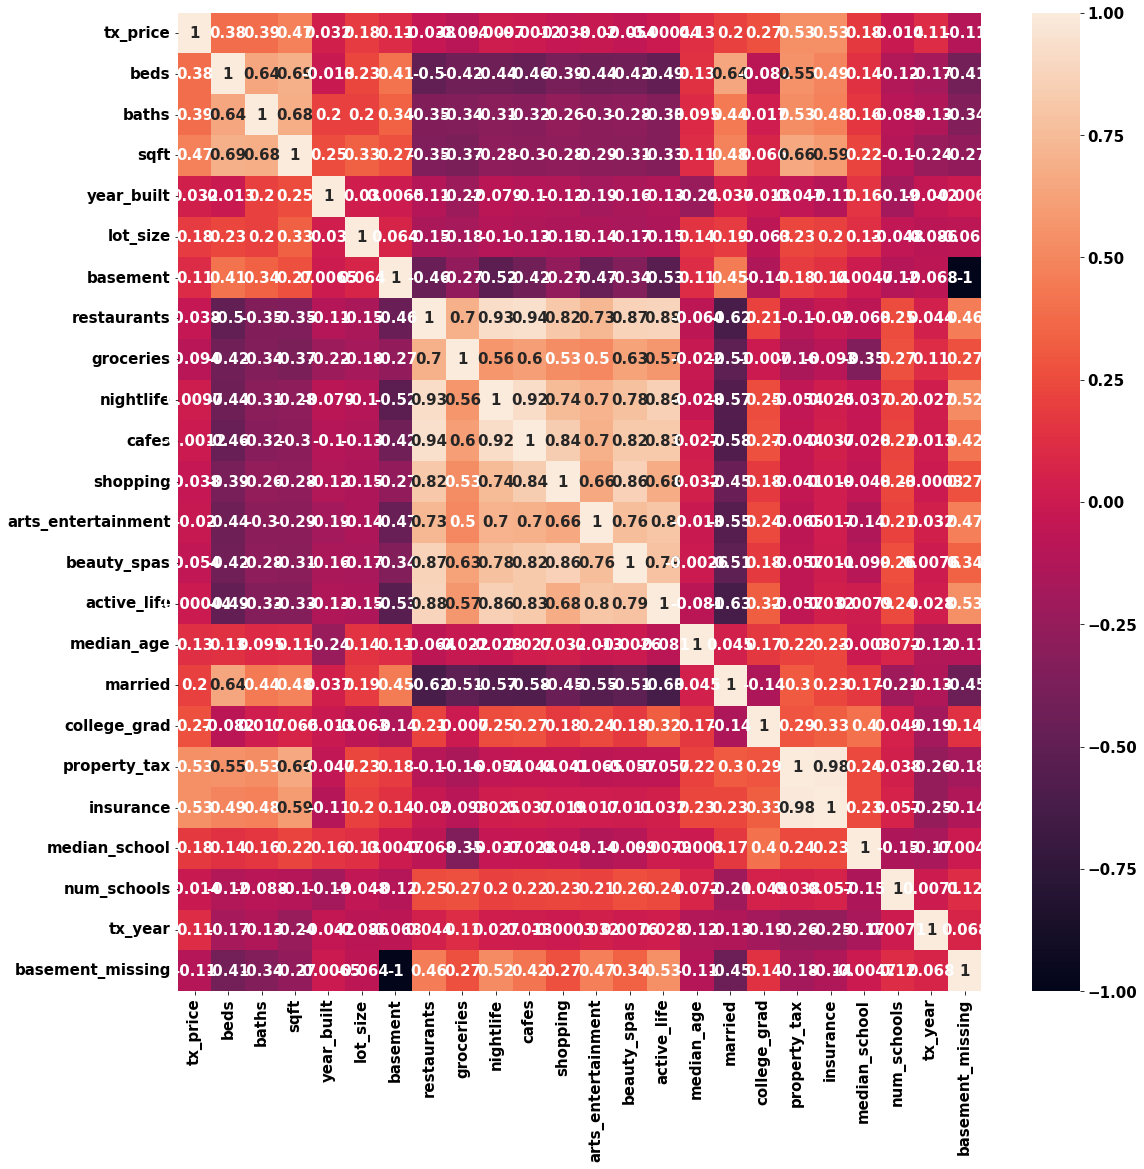

In [23]:
plt.figure(figsize=(18,18))
sns.heatmap(data.select_dtypes(['float64' , 'int64']).corr(),annot=True)
plt.show()

Several variables are highly correlated. For example, active_life, beauty_spas, cafe, nightlife and restaurants are all highly correlated. This multicollinearity might affect model performance, as regression features should be independent.

In [24]:
def corrFilter(x: pd.DataFrame, bound: float):
    xCorr = x.corr()
    xFiltered = xCorr[((xCorr >= bound) | (xCorr <= -bound)) & (xCorr !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates().dropna()
    return xFlattened

corrFilter(data, .7)

basement     basement_missing     -1.000000
groceries    restaurants           0.701522
nightlife    arts_entertainment    0.703782
restaurants  arts_entertainment    0.728020
shopping     nightlife             0.743431
beauty_spas  arts_entertainment    0.758724
             nightlife             0.777402
active_life  beauty_spas           0.785949
             arts_entertainment    0.800959
shopping     restaurants           0.818876
beauty_spas  cafes                 0.822546
active_life  cafes                 0.826934
cafes        shopping              0.837092
nightlife    active_life           0.858935
beauty_spas  shopping              0.861119
             restaurants           0.867817
restaurants  active_life           0.882038
cafes        nightlife             0.923921
nightlife    restaurants           0.926673
cafes        restaurants           0.937615
insurance    property_tax          0.984725
dtype: float64

For linear models, several variables need to be removed from the feature list: ['TractWhite','OHU2010','TractOMultir','TractWhite','HUNVFlag','TractKids','TractSeniors','NUMGQTRS','GroupQuartersFlag','TractSNAP']

In [25]:
corr = data.corr()[['tx_price']].sort_values(by='tx_price', ascending=False)
corr

,tx_price
tx_price,1.000000
property_tax,0.534935
insurance,0.532767
sqft,0.469316
baths,0.388978
beds,0.383695
college_grad,0.269338
married,0.199902
lot_size,0.181893
median_school,0.175684


### 1.3 Understanding the categorical variables

In [26]:
col_cat = data.select_dtypes(include = ['object']).columns.tolist()
col_cat

['property_type', 'exterior_walls', 'roof']

In [27]:
#encoding categorical variables
#le = LabelEncoder()
#le.fit(data['property_type'])
#data['property_type'] = le.transform(data['property_type'])
#data

#### Missing values

In [28]:
data.select_dtypes(include=['object']).isnull().sum()

property_type       0
exterior_walls    223
roof              353
dtype: int64

We’ll want to tell our algorithms that these values are Missing. This is more instructive than simply removing the rows.

In [29]:
for feat in col_cat:
    data[feat].fillna('Missing',inplace=True)

In [30]:
# Number of unique values
# Show the first 5 unique values

for column in col_cat:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

property_type            2	 ['Apartment / Condo / Townhouse', 'Single-Family']
exterior_walls          17	 ['Asbestos shingle', 'Block', 'Brick', 'Brick veneer', 'Combination']
roof                    17	 ['Asbestos', 'Asphalt', 'Built-up', 'Composition', 'Composition Shingle']


In [31]:
#data = data.drop(columns=['roof', 'exterior_walls'])

In [32]:
data.property_type.value_counts()

Single-Family                    1080
Apartment / Condo / Townhouse     802
Name: property_type, dtype: int64

In [33]:
data.exterior_walls.value_counts()

Brick                  686
Siding (Alum/Vinyl)    503
Missing                223
Metal                  120
Combination            107
Wood                    72
Wood Siding             49
Brick veneer            48
Stucco                  26
Other                   10
Concrete                 8
Block                    7
Concrete Block           7
Asbestos shingle         6
Rock, Stone              5
Masonry                  3
Wood Shingle             2
Name: exterior_walls, dtype: int64

In [34]:
data.roof.value_counts()

Composition Shingle      1179
Missing                   353
Asphalt                   132
Shake Shingle              55
Other                      49
Gravel/Rock                30
Wood Shake/ Shingles       30
Roll Composition           12
Slate                       9
Asbestos                    9
asphalt                     5
Composition                 5
Metal                       4
composition                 4
shake-shingle               3
Built-up                    2
asphalt,shake-shingle       1
Name: roof, dtype: int64

From this, we can clean up the classes a bit. We’ll

merge together sparse classes (those with too few observations)
merge classes with similar meanings (e.g. subsume Concrete and Block into the more general Concrete block class.
fix up labelling errors (e.g. concrete should be Concrete).

In [35]:
data.exterior_walls.replace(['Wood Siding', 'Wood Shingle', 'Wood'],
                           'Wood', inplace=True)
data.exterior_walls.replace('Rock, Stone', 'Masonry', inplace=True)
data.exterior_walls.replace(['Concrete','Block'], 'Concrete Block',
                            inplace=True)
data.exterior_walls.replace(['Concrete Block', 'Stucco', 'Concrete',
                           'Block', 'Masonry', 'Other', 
                           'Asbestos shingle', 'Rock, Stone'],
                           'Other', inplace=True)
data.roof.replace('composition', 'Composition',inplace=True)
data.roof.replace(['Composition', 'Wood Shake/ Shingles', 
                 'Composition Shingle'], 'Composition Shingle',
                  inplace=True)
data.roof.replace(['Other', 'Gravel/Rock', 'Roll Composition',
                 'Slate', 'Built-up', 'Asbestos', 'Metal'], 'Other',
                  inplace=True)
data.roof.replace(['asphalt','asphalt,shake-shingle',
                 'shake-shingle'], 'Shake Shingle', inplace=True)



Let’s plot some bar graphs of our three categorical features.

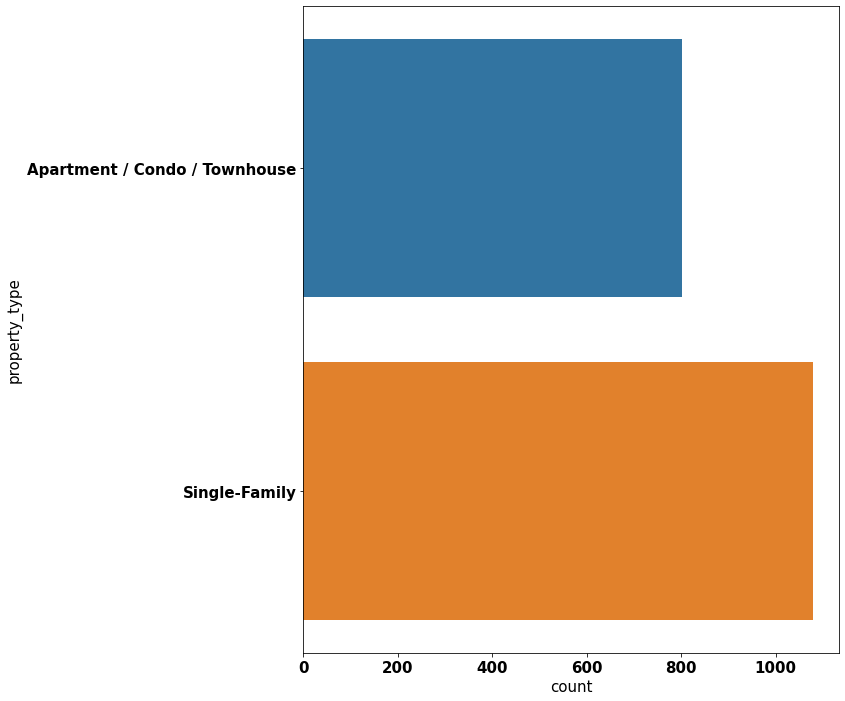

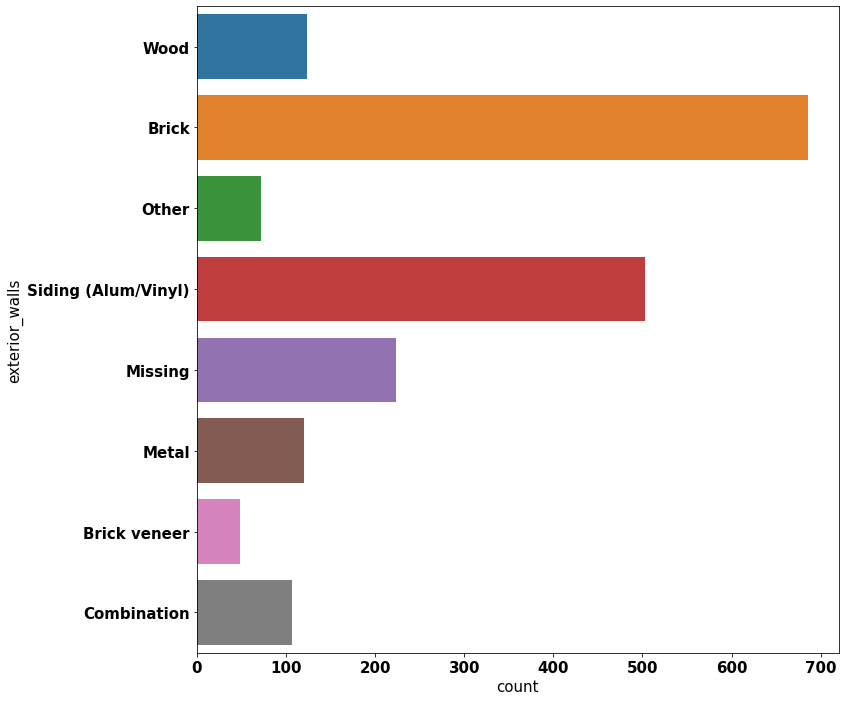

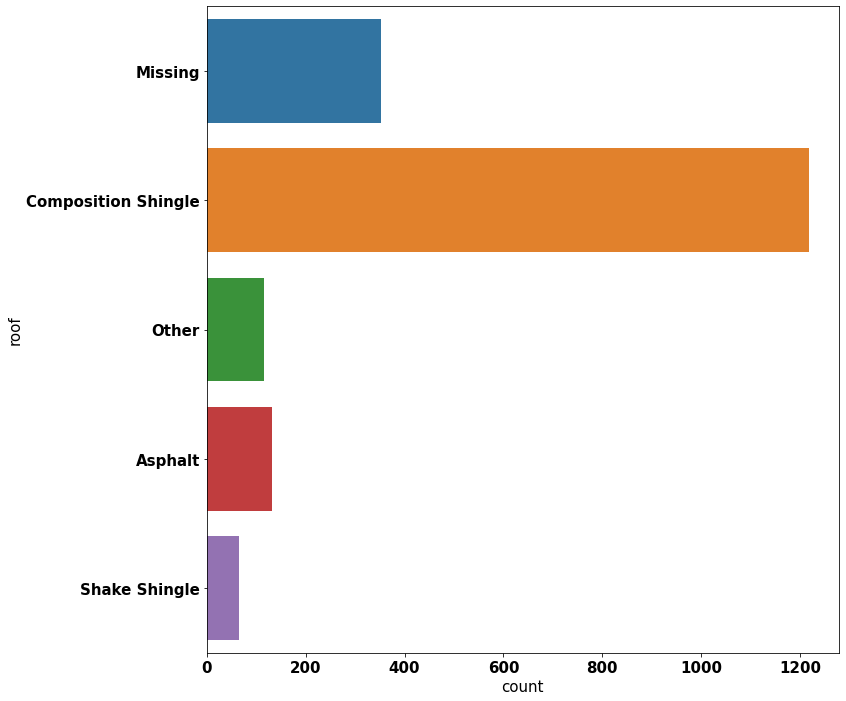

In [36]:
for feat in col_cat:
    sns.countplot(y=feat, data=data)
    plt.tight_layout()
    plt.show()

Note: now we have finished the data cleaning stage (processing the missing values and outliers)

In [37]:
#save a copy of data for ensemble modeling
data_ensemble = data

#### Further EDA
Segmentations combine both numerical and categorical features.

Let’s segment all our categorical variables (property_type, exterior_walls and roof) by our target tx_price. This will provide a detailed look at what might drive property values.

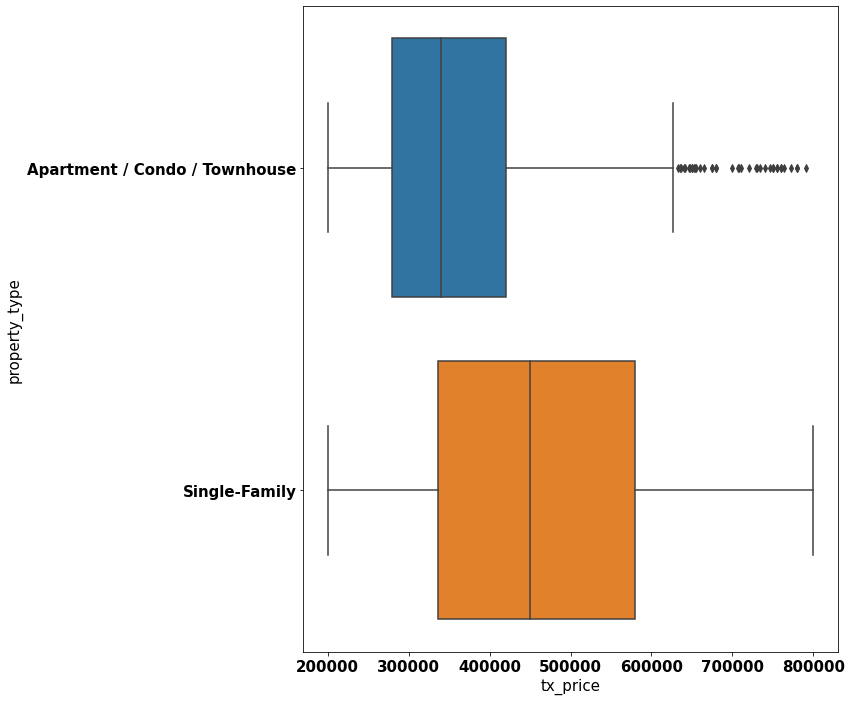

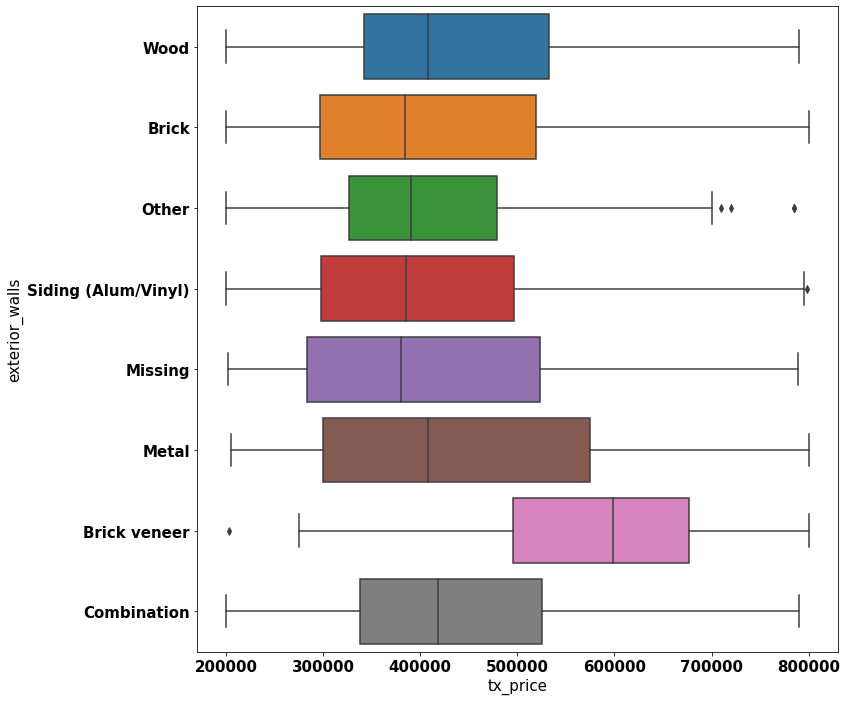

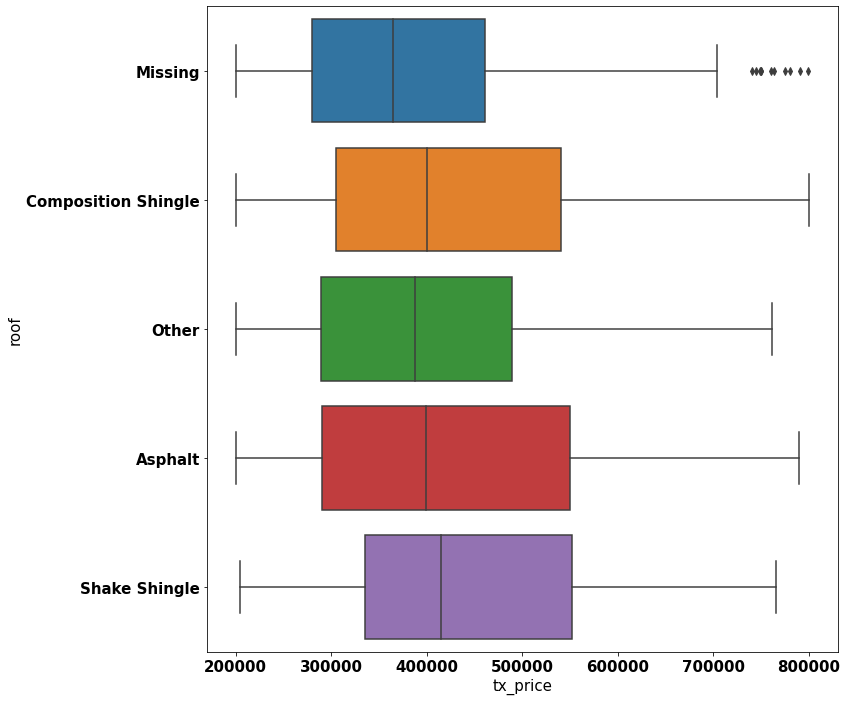

In [38]:
for feat in col_cat:
    sns.boxplot(data=data, x = 'tx_price', y = '{}'.format(feat))
    plt.tight_layout()
    plt.show()

Let’s also look at how property and neighbourhood features differ between single-family homes and apartment/condo/townhouse by using a groupby.

In [39]:
data.groupby('property_type').agg(['mean','median'])

tx_price                beds         \
                                        mean    median      mean median   
property_type                                                             
Apartment / Condo / Townhouse  366705.824190  340000.0  2.602244    3.0   
Single-Family                  464644.711111  450000.0  4.029630    4.0   

                                  baths                sqft          \
                                   mean median         mean  median   
property_type                                                         
Apartment / Condo / Townhouse  2.201995    2.0  1514.523691  1428.0   
Single-Family                  2.862037    3.0  2935.865741  2663.0   

                                year_built              lot_size           \
                                      mean  median          mean   median   
property_type                                                               
Apartment / Condo / Townhouse  1988.985037  1991.0   2427.273067   1424.0   
Single-Family                  1978.523148  1980.0  20417.666667  10758.5   

                               basement        restaurants        groceries  \
                                   mean median        mean median      mean   
property_type                                                                 
Apartment / Condo / Townhouse  0.784289    1.0   58.412718   42.0  5.912718   
Single-Family                  0.951852    1.0   26.672222   14.0  3.453704   

                                     nightlife            cafes         \
                              median      mean median      mean median   
property_type                                                            
Apartment / Condo / Townhouse    5.0  7.851621    4.0  8.037406    5.0   
Single-Family                    2.0  3.007407    1.0  3.308333    1.0   

                                shopping        arts_entertainment         \
                                    mean median               mean median   
property_type                                                               
Apartment / Condo / Townhouse  57.654613   36.0           4.824190    3.0   
Single-Family                  28.289815   13.0           2.318519    1.0   

                              beauty_spas        active_life         \
                                     mean median        mean median   
property_type                                                         
Apartment / Condo / Townhouse   32.074813   26.0   22.384040   14.0   
Single-Family                   16.970370    9.0   10.946296    7.0   

                              median_age           married         \
                                    mean median       mean median   
property_type                                                       
Apartment / Condo / Townhouse  37.204489   35.5  57.562344   62.0   
Single-Family                  39.643519   40.0  77.685185   80.0   

                              college_grad        property_tax         \
                                      mean median         mean median   
property_type                                                           
Apartment / Condo / Townhouse    66.346633   69.0   346.406484  321.0   
Single-Family                    64.128704   65.0   556.383333  516.0   

                                insurance        median_school         \
                                     mean median          mean median   
property_type                                                           
Apartment / Condo / Townhouse  105.685786   96.0      6.382793    7.0   
Single-Family                  166.329630  152.5      6.592593    7.0   

                              num_schools             tx_year          \
                                     mean median         mean  median   
property_type                                                           
Apartment / Condo / Townhouse    2.831671    3.0  2007.933915  2008.0   
Single-Family                    2.7648

In summary, single-family houses are more expensive and larger, while apartment/condo/townhouse dwellings are closer to entertainment/shops and attract younger residents. 

## 2.Feature Engineering

A lot of feature engineering rests on domain expertise.

* One important missing feature is the age of the property!
* Which is simply: *tx_year - year_built*

In [40]:
data.year_built.sort_values().unique()

array([1880, 1892, 1900, 1905, 1918, 1920, 1921, 1924, 1925, 1927, 1929,
       1930, 1932, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015])

In [41]:
data['age'] = data['tx_year'] - data['year_built']

In [42]:
data.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,basement_missing,age
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood,Missing,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013,1,0
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006,0,41
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood,Missing,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012,1,49
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood,Missing,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005,1,5
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002,1,10


In [43]:
data.age.sort_values().unique()

array([ -8,  -7,  -4,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,
         8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,
        21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,
        34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  77,  78,  79,  80,  82,  85,  86,  89,  90,  94,
       101, 103, 104, 110, 113, 114])

In [44]:
data.iloc[:,4::19].sort_values(by='year_built', ascending=False)[:10]

,year_built,median_school
1540,2015,9.0
1864,2015,5.0
1828,2015,4.0
1840,2014,10.0
1769,2014,4.5
1207,2014,8.0
0,2013,9.0
1088,2013,6.0
864,2013,4.0
406,2013,3.5


Some properties are sold before it finished construction.

That is why we have negative *age* values.

In [45]:
data.to_csv('data_processed.csv', index=False) # Now, output to cleaned & engineered data for use

## 3. Modeling
### 3.1. Baseline model-- regularized linear regression

#### Data preparation for linear regression

In [46]:
df = pd.read_csv('data_processed.csv')

In [47]:
df.head()

,tx_price,beds,baths,sqft,year_built,lot_size,property_type,exterior_walls,roof,basement,restaurants,groceries,nightlife,cafes,shopping,arts_entertainment,beauty_spas,active_life,median_age,married,college_grad,property_tax,insurance,median_school,num_schools,tx_year,basement_missing,age
0,295850,1,1,584,2013,0,Apartment / Condo / Townhouse,Wood,Missing,0.0,107,9,30,19,89,6,47,58,33.0,65.0,84.0,234.0,81.0,9.0,3.0,2013,1,0
1,216500,1,1,612,1965,0,Apartment / Condo / Townhouse,Brick,Composition Shingle,1.0,105,15,6,13,87,2,26,14,39.0,73.0,69.0,169.0,51.0,3.0,3.0,2006,0,41
2,279900,1,1,615,1963,0,Apartment / Condo / Townhouse,Wood,Missing,0.0,183,13,31,30,101,10,74,62,28.0,15.0,86.0,216.0,74.0,8.0,3.0,2012,1,49
3,379900,1,1,618,2000,33541,Apartment / Condo / Townhouse,Wood,Missing,0.0,198,9,38,25,127,11,72,83,36.0,25.0,91.0,265.0,92.0,9.0,3.0,2005,1,5
4,340000,1,1,634,1992,0,Apartment / Condo / Townhouse,Brick,Missing,0.0,149,7,22,20,83,10,50,73,37.0,20.0,75.0,88.0,30.0,9.0,3.0,2002,1,10


In [48]:
#drop highly correlate features
df = df.drop(columns=['active_life', 'beauty_spas', 'cafes', 'nightlife'], axis =1)

In [49]:
#one-hot encoding the categorical features
df = pd.get_dummies(df, columns = ['exterior_walls', 
                                   'roof', 
                                   'property_type'])

In [50]:
y = df.tx_price
X = df.drop('tx_price', axis=1)

In [51]:
#test_train splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

#### L1 and L2 regularized linear models

In [52]:
#we use L1 and L2 regularized linear models;
#L1 lasso many coefficients are zeroed out and leads to sparser models;
#feature normalization also happen within the pipeline
pipelines = {
    'lasso' : make_pipeline(StandardScaler(),
              Lasso(random_state=123, tol=1e-2, max_iter=10000)),
    'ridge' : make_pipeline(StandardScaler(),
              Ridge(random_state=123,  tol=1e-2, max_iter=10000))
}

In [53]:
#lasso：the higher the alpha, the most feature coefficients are zero.
#ridge: the higher the alpha, the impact of coefficient shrinkage grows 
lasso_hyperparameters = {
    'lasso__alpha' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10]}
ridge_hyperparameters = {
    'ridge__alpha' : [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5, 10]}

hyperparameters = {
    'lasso' : lasso_hyperparameters,
    'ridge' : ridge_hyperparameters   
}

In [54]:
fitted_models = {}
for name, pipeline in pipelines.items():
    model = GridSearchCV(pipeline, 
                         hyperparameters[name], 
                         cv=10
                         )
    model.fit(X_train, y_train)
    fitted_models[name] = model

In [55]:
#give R2 as the performance score
for name, model in fitted_models.items():
    print( name, model.best_score_ )

lasso 0.4092652420414395
ridge 0.41274254448138564


In [56]:
#apply model to test data
#use R2 and MAE as the metrics: mae measures the average of the residuals. mse measures the variance of the residuals
#adding more features always increase the r2, can serve as a signal for high model complexity (overfitting)
for name, model in fitted_models.items():
    pred = model.predict(X_test)
    print(name)
    print(' — — — —' )
    print('R²:', r2_score(y_test, pred))
    print('MAE:', mean_absolute_error(y_test, pred))
    print()

lasso
 — — — —
R²: 0.4176376889468161
MAE: 88262.15999118793

ridge
 — — — —
R²: 0.41707710655944186
MAE: 88341.5254655491



### 3.2 Ensemble model -- Catboosting model

In [57]:
y1 = data_ensemble['tx_price']
X1 = data_ensemble.drop('tx_price', axis=1)

# train-test splitting
X_train_ens, X_test_ens, y_train_ens, y_test_ens = train_test_split(X1, y1, test_size=0.20,  random_state=42)
categorical_columns_names = list(X1.select_dtypes(include=['object']).columns.values.tolist())
categorical_columns = [X1.columns.get_loc(c) for c in categorical_columns_names]
categorical_columns

[5, 6, 7]

In [70]:
#use optuna for hyperparameter tuning
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X_train_ens, y_train_ens, test_size=0.3)
    param = {
        "loss_function": trial.suggest_categorical("loss_function", ["RMSE", "MAE"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-2, 1e0),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 1e0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 10),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 20),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 2, 20),  
    }
    # Conditional Hyper-Parameters
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    reg = CatBoostRegressor(**param, cat_features=categorical_columns)
    reg.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)
    y_pred = reg.predict(valid_x)
    score = mean_absolute_error(valid_y, y_pred)
    #r2 
    #score = r2_score(y_test_ens, y_pred)
    return score

In [71]:
study = optuna.create_study(sampler=TPESampler(), direction="minimize")
study.optimize(objective, n_trials=100, timeout=600) # Run for 10 minutes
print("Number of completed trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("\tBest Score: {}".format(trial.value))
print("\tBest Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-08-31 11:13:13,927] A new study created in memory with name: no-name-8b03e600-f586-43ad-a0e5-a9e590bfb8d4
[I 2022-08-31 11:13:22,094] Trial 0 finished with value: 77940.84096304468 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.004824373001686779, 'l2_leaf_reg': 0.12278272314369694, 'colsample_bylevel': 0.056678346450896123, 'depth': 10, 'boosting_type': 'Plain', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 13, 'one_hot_max_size': 14, 'subsample': 0.16154763790672388}. Best is trial 0 with value: 77940.84096304468.
[I 2022-08-31 11:13:29,197] Trial 1 finished with value: 121505.65466565105 and parameters: {'loss_function': 'RMSE', 'learning_rate': 0.0013633895047800145, 'l2_leaf_reg': 0.49247800699283223, 'colsample_bylevel': 0.01125349525040613, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'min_data_in_leaf': 7, 'one_hot_max_size': 9}. Best is trial 0 with value: 77940.84096304468.
[I 2022-08-31 11:13:37,546] Trial 2 finished with value:

[I 2022-08-31 11:16:03,745] Trial 20 finished with value: 55143.23665210451 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.23793227649350102, 'l2_leaf_reg': 0.2699107018554441, 'colsample_bylevel': 0.06401642191521491, 'depth': 8, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 14, 'one_hot_max_size': 14, 'subsample': 0.16320943453443254}. Best is trial 19 with value: 50341.095382933134.
[I 2022-08-31 11:16:08,176] Trial 21 finished with value: 51738.558841236554 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.32278104896799137, 'l2_leaf_reg': 0.47037091384899327, 'colsample_bylevel': 0.07074095366558722, 'depth': 4, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 18, 'one_hot_max_size': 15, 'subsample': 0.43024348945823043}. Best is trial 19 with value: 50341.095382933134.
[I 2022-08-31 11:16:18,240] Trial 22 finished with value: 50961.398291276804 and parameters: {'loss_function': 'MAE', 'learning_

[I 2022-08-31 11:19:44,546] Trial 39 finished with value: 63695.972560930975 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.028911888577819136, 'l2_leaf_reg': 0.5539584700964878, 'colsample_bylevel': 0.04597149217739117, 'depth': 5, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'min_data_in_leaf': 9, 'one_hot_max_size': 16, 'bagging_temperature': 7.680863807187382}. Best is trial 24 with value: 46111.157987019375.
[I 2022-08-31 11:19:56,181] Trial 40 finished with value: 101520.04086679654 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.0009689611128698101, 'l2_leaf_reg': 0.2266152733893707, 'colsample_bylevel': 0.07757295637491622, 'depth': 6, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 10, 'one_hot_max_size': 5, 'subsample': 0.4907472120201737}. Best is trial 24 with value: 46111.157987019375.
[I 2022-08-31 11:20:10,057] Trial 41 finished with value: 52163.3497019519 and parameters: {'loss_function': 'MAE', 'learni

[I 2022-08-31 11:22:28,080] Trial 58 finished with value: 55413.87149808547 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.10864624815543016, 'l2_leaf_reg': 0.27760380699875564, 'colsample_bylevel': 0.04907403765685879, 'depth': 7, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 15, 'one_hot_max_size': 11, 'subsample': 0.5485169043881234}. Best is trial 51 with value: 45289.55818942851.
[I 2022-08-31 11:22:35,819] Trial 59 finished with value: 119228.09846009538 and parameters: {'loss_function': 'MAE', 'learning_rate': 0.00026622217987828234, 'l2_leaf_reg': 0.43189702308279215, 'colsample_bylevel': 0.020416481893969454, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'min_data_in_leaf': 11, 'one_hot_max_size': 14, 'subsample': 0.7888073237162768}. Best is trial 51 with value: 45289.55818942851.
[I 2022-08-31 11:22:37,556] Trial 60 finished with value: 57313.70580808812 and parameters: {'loss_function': 'MAE', 'learning_

Number of completed trials: 67
Best trial:
	Best Score: 45289.55818942851
	Best Params: 
    loss_function: MAE
    learning_rate: 0.09646279545889577
    l2_leaf_reg: 0.42795649944560926
    colsample_bylevel: 0.0997725793903197
    depth: 5
    boosting_type: Ordered
    bootstrap_type: Bernoulli
    min_data_in_leaf: 13
    one_hot_max_size: 12
    subsample: 0.7747784485189209


In [72]:
cb = CatBoostRegressor(**trial.params)
cb.fit(X_train_ens, y_train_ens,cat_features=categorical_columns)


0:	learn: 117950.7522195	total: 5.57ms	remaining: 5.56s
1:	learn: 113602.2120470	total: 11.5ms	remaining: 5.72s
2:	learn: 112006.9311010	total: 24.6ms	remaining: 8.16s
3:	learn: 108565.3081223	total: 36.7ms	remaining: 9.14s
4:	learn: 105376.0026185	total: 53.1ms	remaining: 10.6s
5:	learn: 104726.9815331	total: 56.5ms	remaining: 9.36s
6:	learn: 101272.0109161	total: 70.3ms	remaining: 9.97s
7:	learn: 101262.0744046	total: 74.1ms	remaining: 9.19s
8:	learn: 99143.1683881	total: 81.6ms	remaining: 8.99s
9:	learn: 96958.3683786	total: 89.5ms	remaining: 8.86s
10:	learn: 92065.6153493	total: 102ms	remaining: 9.14s
11:	learn: 89959.7948141	total: 119ms	remaining: 9.8s
12:	learn: 88487.0838472	total: 130ms	remaining: 9.84s
13:	learn: 88481.1000980	total: 132ms	remaining: 9.26s
14:	learn: 85751.3636610	total: 144ms	remaining: 9.47s
15:	learn: 83843.0791061	total: 153ms	remaining: 9.39s
16:	learn: 82517.1782522	total: 162ms	remaining: 9.35s
17:	learn: 81430.4384995	total: 170ms	remaining: 9.27s
18:

152:	learn: 43391.2093582	total: 1.22s	remaining: 6.75s
153:	learn: 43299.2963708	total: 1.23s	remaining: 6.75s
154:	learn: 43258.6502636	total: 1.24s	remaining: 6.74s
155:	learn: 43220.8096525	total: 1.25s	remaining: 6.74s
156:	learn: 43215.4708866	total: 1.25s	remaining: 6.73s
157:	learn: 43207.5327246	total: 1.26s	remaining: 6.73s
158:	learn: 43120.3856439	total: 1.28s	remaining: 6.78s
159:	learn: 43114.1336133	total: 1.29s	remaining: 6.77s
160:	learn: 43045.0744613	total: 1.3s	remaining: 6.75s
161:	learn: 43019.3849298	total: 1.3s	remaining: 6.74s
162:	learn: 42985.5981274	total: 1.3s	remaining: 6.7s
163:	learn: 42981.2609507	total: 1.31s	remaining: 6.71s
164:	learn: 42909.0935381	total: 1.32s	remaining: 6.7s
165:	learn: 42798.2975834	total: 1.33s	remaining: 6.68s
166:	learn: 42742.3974738	total: 1.34s	remaining: 6.7s
167:	learn: 42739.2142375	total: 1.36s	remaining: 6.73s
168:	learn: 42691.1498007	total: 1.37s	remaining: 6.74s
169:	learn: 42660.9241300	total: 1.38s	remaining: 6.73

307:	learn: 37542.4760119	total: 2.48s	remaining: 5.57s
308:	learn: 37521.6894113	total: 2.49s	remaining: 5.56s
309:	learn: 37513.2426668	total: 2.49s	remaining: 5.54s
310:	learn: 37379.9879960	total: 2.51s	remaining: 5.55s
311:	learn: 37341.6042741	total: 2.52s	remaining: 5.55s
312:	learn: 37280.0621470	total: 2.52s	remaining: 5.54s
313:	learn: 37247.4327869	total: 2.53s	remaining: 5.53s
314:	learn: 37198.4574959	total: 2.54s	remaining: 5.51s
315:	learn: 37192.7152453	total: 2.54s	remaining: 5.51s
316:	learn: 37176.2023903	total: 2.55s	remaining: 5.5s
317:	learn: 37145.0331202	total: 2.56s	remaining: 5.49s
318:	learn: 37142.7462845	total: 2.56s	remaining: 5.47s
319:	learn: 37121.2469792	total: 2.57s	remaining: 5.46s
320:	learn: 37080.6575662	total: 2.58s	remaining: 5.45s
321:	learn: 37080.4788566	total: 2.58s	remaining: 5.43s
322:	learn: 37053.3680879	total: 2.59s	remaining: 5.42s
323:	learn: 37052.4135952	total: 2.59s	remaining: 5.41s
324:	learn: 37030.6278383	total: 2.6s	remaining: 

455:	learn: 34501.6787505	total: 3.54s	remaining: 4.23s
456:	learn: 34491.2498498	total: 3.56s	remaining: 4.23s
457:	learn: 34479.9607977	total: 3.57s	remaining: 4.22s
458:	learn: 34471.0898109	total: 3.57s	remaining: 4.21s
459:	learn: 34435.5672821	total: 3.58s	remaining: 4.2s
460:	learn: 34415.5874285	total: 3.59s	remaining: 4.2s
461:	learn: 34410.7263851	total: 3.6s	remaining: 4.2s
462:	learn: 34394.1946326	total: 3.61s	remaining: 4.19s
463:	learn: 34372.8406402	total: 3.62s	remaining: 4.18s
464:	learn: 34371.8751703	total: 3.62s	remaining: 4.17s
465:	learn: 34366.8537754	total: 3.63s	remaining: 4.16s
466:	learn: 34365.5699479	total: 3.64s	remaining: 4.15s
467:	learn: 34323.3892289	total: 3.65s	remaining: 4.15s
468:	learn: 34322.2462488	total: 3.65s	remaining: 4.13s
469:	learn: 34314.3116910	total: 3.66s	remaining: 4.13s
470:	learn: 34289.7535817	total: 3.67s	remaining: 4.12s
471:	learn: 34289.7107392	total: 3.67s	remaining: 4.11s
472:	learn: 34269.8018952	total: 3.68s	remaining: 4.

605:	learn: 32674.0690021	total: 4.6s	remaining: 2.99s
606:	learn: 32670.4096663	total: 4.61s	remaining: 2.99s
607:	learn: 32650.9650868	total: 4.62s	remaining: 2.98s
608:	learn: 32649.9107839	total: 4.62s	remaining: 2.97s
609:	learn: 32644.3773936	total: 4.63s	remaining: 2.96s
610:	learn: 32633.9619066	total: 4.64s	remaining: 2.95s
611:	learn: 32632.9143375	total: 4.64s	remaining: 2.94s
612:	learn: 32626.5748729	total: 4.65s	remaining: 2.93s
613:	learn: 32618.1129305	total: 4.65s	remaining: 2.92s
614:	learn: 32611.2700384	total: 4.66s	remaining: 2.92s
615:	learn: 32611.1851324	total: 4.67s	remaining: 2.91s
616:	learn: 32579.6155093	total: 4.67s	remaining: 2.9s
617:	learn: 32545.5951837	total: 4.68s	remaining: 2.89s
618:	learn: 32535.8880762	total: 4.69s	remaining: 2.89s
619:	learn: 32530.1274836	total: 4.71s	remaining: 2.88s
620:	learn: 32527.8494930	total: 4.71s	remaining: 2.87s
621:	learn: 32527.3286431	total: 4.71s	remaining: 2.87s
622:	learn: 32519.9278051	total: 4.72s	remaining: 

752:	learn: 30863.9967787	total: 5.67s	remaining: 1.86s
753:	learn: 30854.6075104	total: 5.68s	remaining: 1.85s
754:	learn: 30852.3072430	total: 5.69s	remaining: 1.84s
755:	learn: 30841.9786029	total: 5.7s	remaining: 1.84s
756:	learn: 30827.0132268	total: 5.71s	remaining: 1.83s
757:	learn: 30775.7604208	total: 5.71s	remaining: 1.82s
758:	learn: 30766.9520626	total: 5.73s	remaining: 1.82s
759:	learn: 30763.6270379	total: 5.74s	remaining: 1.81s
760:	learn: 30756.6778287	total: 5.77s	remaining: 1.81s
761:	learn: 30736.9432134	total: 5.79s	remaining: 1.81s
762:	learn: 30736.8803168	total: 5.79s	remaining: 1.8s
763:	learn: 30730.6749026	total: 5.8s	remaining: 1.79s
764:	learn: 30727.6375853	total: 5.81s	remaining: 1.78s
765:	learn: 30724.3338808	total: 5.82s	remaining: 1.78s
766:	learn: 30723.4930116	total: 5.82s	remaining: 1.77s
767:	learn: 30706.0781996	total: 5.83s	remaining: 1.76s
768:	learn: 30689.1595279	total: 5.84s	remaining: 1.75s
769:	learn: 30682.2654888	total: 5.84s	remaining: 1

903:	learn: 29737.2765722	total: 6.83s	remaining: 726ms
904:	learn: 29734.5573871	total: 6.84s	remaining: 718ms
905:	learn: 29734.1809166	total: 6.85s	remaining: 710ms
906:	learn: 29730.5596399	total: 6.86s	remaining: 704ms
907:	learn: 29730.5358873	total: 6.87s	remaining: 696ms
908:	learn: 29717.9994142	total: 6.88s	remaining: 688ms
909:	learn: 29717.9947371	total: 6.88s	remaining: 680ms
910:	learn: 29716.2908780	total: 6.9s	remaining: 674ms
911:	learn: 29716.2873452	total: 6.9s	remaining: 666ms
912:	learn: 29715.0240955	total: 6.91s	remaining: 659ms
913:	learn: 29708.7479135	total: 6.92s	remaining: 651ms
914:	learn: 29687.0678623	total: 6.93s	remaining: 643ms
915:	learn: 29657.1610956	total: 6.93s	remaining: 636ms
916:	learn: 29647.2851981	total: 6.94s	remaining: 628ms
917:	learn: 29624.0999130	total: 6.95s	remaining: 621ms
918:	learn: 29622.9820963	total: 6.96s	remaining: 613ms
919:	learn: 29614.5638030	total: 6.97s	remaining: 606ms
920:	learn: 29604.9586716	total: 6.99s	remaining: 

In [73]:
#get default parameters
cb = CatBoostRegressor()
cb.fit(X_train_ens, y_train_ens,cat_features=categorical_columns)
cb.get_all_params()

Learning rate set to 0.041976
0:	learn: 145627.3427191	total: 18.5ms	remaining: 18.5s
1:	learn: 142156.2995424	total: 34.5ms	remaining: 17.2s
2:	learn: 138676.4608976	total: 57.5ms	remaining: 19.1s
3:	learn: 135393.7012894	total: 125ms	remaining: 31s
4:	learn: 132278.1549751	total: 141ms	remaining: 28s
5:	learn: 129654.6656709	total: 177ms	remaining: 29.3s
6:	learn: 126643.3322758	total: 205ms	remaining: 29.1s
7:	learn: 124162.1780298	total: 221ms	remaining: 27.4s
8:	learn: 121598.7044733	total: 244ms	remaining: 26.8s
9:	learn: 119144.0269805	total: 271ms	remaining: 26.8s
10:	learn: 116837.6686747	total: 289ms	remaining: 25.9s
11:	learn: 114650.1989139	total: 309ms	remaining: 25.4s
12:	learn: 112267.2121129	total: 323ms	remaining: 24.5s
13:	learn: 110186.5348938	total: 336ms	remaining: 23.7s
14:	learn: 108657.9830252	total: 343ms	remaining: 22.5s
15:	learn: 106958.8147793	total: 368ms	remaining: 22.6s
16:	learn: 105329.1329657	total: 383ms	remaining: 22.1s
17:	learn: 103602.5560000	tot

154:	learn: 56478.4776866	total: 3.4s	remaining: 18.6s
155:	learn: 56423.5122294	total: 3.43s	remaining: 18.5s
156:	learn: 56319.6802245	total: 3.46s	remaining: 18.6s
157:	learn: 56269.2551969	total: 3.48s	remaining: 18.6s
158:	learn: 56168.8711419	total: 3.5s	remaining: 18.5s
159:	learn: 56092.8129449	total: 3.52s	remaining: 18.5s
160:	learn: 56007.5941184	total: 3.53s	remaining: 18.4s
161:	learn: 55866.4417709	total: 3.55s	remaining: 18.4s
162:	learn: 55727.9088199	total: 3.56s	remaining: 18.3s
163:	learn: 55663.2870439	total: 3.58s	remaining: 18.3s
164:	learn: 55536.4701259	total: 3.6s	remaining: 18.2s
165:	learn: 55484.4819402	total: 3.63s	remaining: 18.2s
166:	learn: 55444.4498895	total: 3.65s	remaining: 18.2s
167:	learn: 55357.1486461	total: 3.67s	remaining: 18.2s
168:	learn: 55208.1343012	total: 3.69s	remaining: 18.2s
169:	learn: 55119.2597958	total: 3.71s	remaining: 18.1s
170:	learn: 55031.3821465	total: 3.73s	remaining: 18.1s
171:	learn: 54963.7667405	total: 3.75s	remaining: 1

309:	learn: 45620.3687763	total: 7.09s	remaining: 15.8s
310:	learn: 45613.1242009	total: 7.12s	remaining: 15.8s
311:	learn: 45523.9101226	total: 7.14s	remaining: 15.7s
312:	learn: 45504.1703315	total: 7.19s	remaining: 15.8s
313:	learn: 45460.8014041	total: 7.21s	remaining: 15.7s
314:	learn: 45403.5628373	total: 7.23s	remaining: 15.7s
315:	learn: 45396.0976835	total: 7.26s	remaining: 15.7s
316:	learn: 45325.8365897	total: 7.29s	remaining: 15.7s
317:	learn: 45230.2130962	total: 7.31s	remaining: 15.7s
318:	learn: 45157.6293704	total: 7.35s	remaining: 15.7s
319:	learn: 45136.4974319	total: 7.37s	remaining: 15.7s
320:	learn: 45086.2751660	total: 7.4s	remaining: 15.7s
321:	learn: 45039.4900107	total: 7.42s	remaining: 15.6s
322:	learn: 44984.0561378	total: 7.44s	remaining: 15.6s
323:	learn: 44922.2466974	total: 7.45s	remaining: 15.5s
324:	learn: 44913.9944536	total: 7.47s	remaining: 15.5s
325:	learn: 44885.6806600	total: 7.49s	remaining: 15.5s
326:	learn: 44808.9826546	total: 7.5s	remaining: 

460:	learn: 39152.1240391	total: 10.8s	remaining: 12.6s
461:	learn: 39113.4391814	total: 10.8s	remaining: 12.6s
462:	learn: 39096.6205381	total: 10.8s	remaining: 12.6s
463:	learn: 39056.4752169	total: 10.9s	remaining: 12.6s
464:	learn: 39015.0841442	total: 10.9s	remaining: 12.5s
465:	learn: 38975.0473281	total: 10.9s	remaining: 12.5s
466:	learn: 38967.8451049	total: 11s	remaining: 12.5s
467:	learn: 38932.8255300	total: 11s	remaining: 12.5s
468:	learn: 38930.6668027	total: 11s	remaining: 12.5s
469:	learn: 38884.9944875	total: 11s	remaining: 12.4s
470:	learn: 38831.5134365	total: 11.1s	remaining: 12.4s
471:	learn: 38781.6505915	total: 11.1s	remaining: 12.4s
472:	learn: 38742.4568223	total: 11.1s	remaining: 12.4s
473:	learn: 38668.0587596	total: 11.1s	remaining: 12.3s
474:	learn: 38631.5461430	total: 11.2s	remaining: 12.3s
475:	learn: 38622.7810286	total: 11.2s	remaining: 12.3s
476:	learn: 38614.9305301	total: 11.2s	remaining: 12.3s
477:	learn: 38590.1758247	total: 11.2s	remaining: 12.3s


609:	learn: 34197.4553956	total: 14.4s	remaining: 9.24s
610:	learn: 34135.6261556	total: 14.5s	remaining: 9.23s
611:	learn: 34099.5727772	total: 14.5s	remaining: 9.2s
612:	learn: 34039.1034720	total: 14.6s	remaining: 9.19s
613:	learn: 34022.3419763	total: 14.6s	remaining: 9.19s
614:	learn: 34007.6149247	total: 14.6s	remaining: 9.16s
615:	learn: 34004.9968568	total: 14.7s	remaining: 9.14s
616:	learn: 33980.7376090	total: 14.7s	remaining: 9.12s
617:	learn: 33961.0616620	total: 14.7s	remaining: 9.09s
618:	learn: 33945.0501255	total: 14.7s	remaining: 9.07s
619:	learn: 33909.0530195	total: 14.8s	remaining: 9.04s
620:	learn: 33867.2952562	total: 14.8s	remaining: 9.02s
621:	learn: 33863.2496778	total: 14.8s	remaining: 8.99s
622:	learn: 33844.1966916	total: 14.8s	remaining: 8.98s
623:	learn: 33811.9456223	total: 14.9s	remaining: 8.95s
624:	learn: 33755.1235824	total: 14.9s	remaining: 8.93s
625:	learn: 33748.7938697	total: 14.9s	remaining: 8.91s
626:	learn: 33725.7058344	total: 15s	remaining: 8

759:	learn: 30468.1015977	total: 19.9s	remaining: 6.3s
760:	learn: 30437.8637123	total: 20.1s	remaining: 6.3s
761:	learn: 30420.8448928	total: 20.1s	remaining: 6.29s
762:	learn: 30401.5849162	total: 20.2s	remaining: 6.27s
763:	learn: 30366.1784148	total: 20.3s	remaining: 6.26s
764:	learn: 30341.6237445	total: 20.3s	remaining: 6.24s
765:	learn: 30292.7967666	total: 20.4s	remaining: 6.22s
766:	learn: 30291.2626598	total: 20.4s	remaining: 6.2s
767:	learn: 30268.3176012	total: 20.4s	remaining: 6.18s
768:	learn: 30237.3488108	total: 20.5s	remaining: 6.16s
769:	learn: 30196.6087244	total: 20.5s	remaining: 6.14s
770:	learn: 30182.7366399	total: 20.6s	remaining: 6.11s
771:	learn: 30135.5581361	total: 20.6s	remaining: 6.09s
772:	learn: 30104.7503589	total: 20.8s	remaining: 6.1s
773:	learn: 30074.7263015	total: 20.8s	remaining: 6.08s
774:	learn: 30043.8735875	total: 20.9s	remaining: 6.06s
775:	learn: 30028.4582189	total: 20.9s	remaining: 6.04s
776:	learn: 30013.8222127	total: 21s	remaining: 6.03

910:	learn: 27363.1619940	total: 28.6s	remaining: 2.8s
911:	learn: 27348.4501550	total: 28.6s	remaining: 2.76s
912:	learn: 27321.7233807	total: 28.7s	remaining: 2.73s
913:	learn: 27299.5351528	total: 28.7s	remaining: 2.7s
914:	learn: 27291.5337152	total: 28.7s	remaining: 2.67s
915:	learn: 27284.2256283	total: 28.8s	remaining: 2.64s
916:	learn: 27272.1599933	total: 28.8s	remaining: 2.6s
917:	learn: 27271.5381076	total: 28.8s	remaining: 2.57s
918:	learn: 27242.3517406	total: 28.8s	remaining: 2.54s
919:	learn: 27235.7040537	total: 28.9s	remaining: 2.51s
920:	learn: 27219.2655748	total: 28.9s	remaining: 2.48s
921:	learn: 27194.6699474	total: 28.9s	remaining: 2.44s
922:	learn: 27165.8810402	total: 28.9s	remaining: 2.41s
923:	learn: 27149.3540331	total: 28.9s	remaining: 2.38s
924:	learn: 27140.3863376	total: 28.9s	remaining: 2.35s
925:	learn: 27106.1652589	total: 29s	remaining: 2.31s
926:	learn: 27090.2736334	total: 29s	remaining: 2.28s
927:	learn: 27059.3199150	total: 29s	remaining: 2.25s
9

{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCount=15:CtrBorderType=Uniform:Prior=0/1'],
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'fold_permutation_block': 0,
 'leaf_estimation_method': 'Newton',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'ctr_leaf_count_limit': 18446744073709551615,
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'Counter:CtrBorderCou

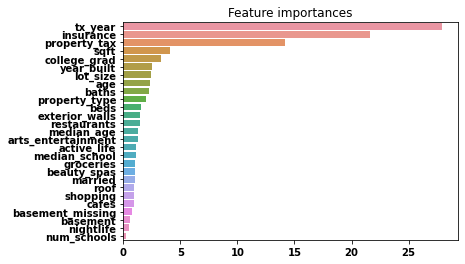

In [66]:
importances = cb.feature_importances_
cb_importances = pd.Series(importances, index=X_train_ens.columns).sort_values(ascending=False)

ax = sns.barplot(y=cb_importances.index, x = cb_importances.values).set(title='Feature importances')
plt.show()


In [67]:
predictions = cb.predict(X_test_ens)

In [68]:
mean_absolute_error(y_test_ens, predictions)

46413.10796513496

Catboost's default setting is already giving the lowest MAE amongst other models!

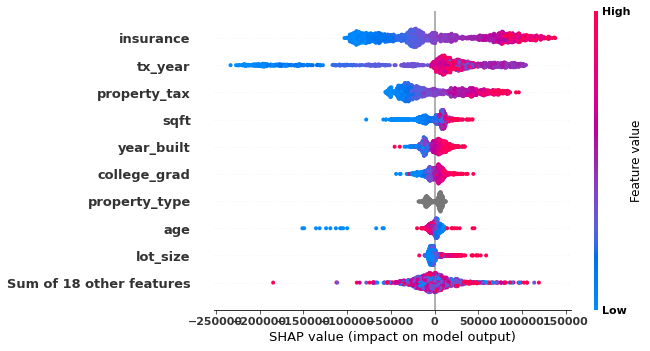

In [69]:
#get shap values
explainer = shap.Explainer(cb)
shap_values = explainer(X_train_ens)
shap.plots.beeswarm(shap_values)

## 4.Results

#### 3 different models are tested with MAE:
* Lasso (tuned): 46052
* Ridge (tuned): 45025
* Catboost (default): 43525


Next Step: Tuning parameters of Catboosting model, such as learning_rate, depth, l2_leaf_reg, etc.
There is no overfitting on the last iterations of training (the training does not converge) — increase the learning rate.
Overfitting is detected — decrease the learning rate
Values in the range from 6 to 10 are recommended.
coefficient at the L2 regularization term of the cost function.  2 and 30, is a good starting point.